In [1]:
from google.cloud import vision
from google.cloud import storage
from PIL import Image
import numpy as np
import os, sys
import csv  
from io import BytesIO
from IPython import display

import torch
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

import scipy
import h5py

from tensorflow.keras.layers import StringLookup

from ML_helper import *
from corrections import *
from image_reading import * 
from handling import *
from preprocessing import * 

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"
client = vision.ImageAnnotatorClient()

In [2]:
random_files = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=False)
np.random.shuffle(random_files)

In [3]:
def extract_ID_handwriting(frame, paragraph_vertices, verbose=False):
        
    padx = 60
    pady = 30

    #firstly find the box around the identity, and also calculate the approx angle of rotation of that box. 
    adapted_para_box = paragraph_vertices.copy()

    x = np.argsort(paragraph_vertices[:,0])
    y = np.argsort(paragraph_vertices[:,1])


    adapted_para_box[x[:2],0] = np.max( np.stack(( paragraph_vertices[x[:2],0] - padx , [0,0] )), axis=0)

    adapted_para_box[x[2:],0] = np.min( np.stack(( paragraph_vertices[x[2:],0] + 1.2*padx , [frame.shape[1] - 1,frame.shape[1] - 1] )), axis=0)

    adapted_para_box[y[:2],1] = np.max( np.stack(( paragraph_vertices[y[:2],1] - pady, [0,0] )), axis=0) 
    adapted_para_box[y[2:],1] = np.min( np.stack(( paragraph_vertices[y[2:],1] + pady , [frame.shape[0] - 1,frame.shape[0] - 1])), axis=0)


    rel_area = polygon(adapted_para_box[:,1], adapted_para_box[:,0]) 
    mask1 = np.zeros(frame.shape[:2], dtype=np.uint8)
    mask1[rel_area] = 1

    miny, maxy, minx, maxx = np.min(adapted_para_box[:,0]), np.max(adapted_para_box[:,0]), np.min(adapted_para_box[:,1]), np.max(adapted_para_box[:,1])


    idx = paragraph_vertices[:,1].argsort()[:2]
    dx = paragraph_vertices[idx[1],0] - paragraph_vertices[idx[0],0]
    dy = paragraph_vertices[idx[1],1] - paragraph_vertices[idx[0],1]

    angle = np.arctan2(dy,dx)


    if verbose:
        fig,ax = plt.subplots(1,6,dpi=250)
        ax[0].imshow(frame)
    frame = frame*mask1[...,None] #mask the image

    if verbose: ax[1].imshow(frame)

    frame = np.mean(frame, axis=2)
    frame = frame[minx:maxx, miny:maxy]

    if verbose: ax[2].imshow(frame)

    frame = rotate(frame, -angle, resize=False, ) #rotate the image
    # frame = (1-frame) #invert and threshold.
    # frame[frame < 0.5] = 0
    # frame[frame !=0] = 1

    if verbose: ax[3].imshow(frame)


    frame = zero_printed_text(frame, threshold = 30) #threshold needs to be found algorithmically.


    hist = np.histogram(frame, bins=100)
    peaks,_ = scipy.signal.find_peaks(hist[0], height=1000, distance=7)

    if len(peaks) == 2:
        peak_handwriting = peaks[0]
        peak_background = peaks[1]

        thresh = 1*hist[1][peak_background]/4  + 3*hist[1][peak_handwriting]/4
    else:
        thresh = frame.max()*0.85
        


    frame[frame>thresh] = 0 
    frame[frame!=0] = 1

    if verbose: ax[4].imshow(frame)


    from skimage.segmentation import clear_border
    # kernel = np.ones((5, 5), np.uint8)
    # frame = cv2.erode(frame, kernel, iterations=1)
    
    # frame = clear_border(frame)

    if verbose: ax[5].imshow(frame)

    return frame

In [4]:
def mask_and_remove(frame, verbose=False):
    if verbose: fig,ax = plt.subplots(1,3,dpi=250)
    if verbose: ax[0].imshow(frame)

    # Average out the RGB axis
    averaged_frame = np.mean(frame,axis=2)
    if verbose: ax[1].imshow(averaged_frame)


    # White background masking
    hist = np.histogram(averaged_frame, bins=100)
    centers = 0.5*(hist[1][1:]+ hist[1][:-1])

    thresh_val = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
    upper_thresh = centers[thresh_val] * 0.95

    # Dark writing masking. Mask based on central row of frame
    frame_shape = np.shape(averaged_frame)
    row1 = -averaged_frame[2 * frame_shape[0] // 5][100:-100]
    row2 = -averaged_frame[3 * frame_shape[0] // 5][100:-100]
    rows = np.concatenate((row1, row2))
    row_mean = np.mean(rows)
    row_max = np.max(rows)
    row_min = np.min(rows)
    peaks,_ = scipy.signal.find_peaks(rows, height = row_mean + ((row_max - row_min) / 5), distance=4)

    values = []
    for peak in peaks:
        values.append(-rows[peak])

    sorted_values = np.sort(values)

    lower_thresh = sorted_values[0] * 1

    if verbose: print('(upper thresh, lower_thresh) = (%.2f, %.2f)' %(upper_thresh, lower_thresh))

    averaged_frame[averaged_frame>upper_thresh] = 0
    averaged_frame[averaged_frame<lower_thresh] = 0
    averaged_frame[averaged_frame!=0] = 255

    if verbose: ax[2].imshow(averaged_frame)

    return averaged_frame

In [5]:
def consecutive_runs(a, value):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, value).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    lengths = ranges[:,1] - ranges[:,0]
    return lengths

In [6]:
def remove_deltas(frame, width, padx=60, pady=30, verbose=False):
    if verbose: fig,ax = plt.subplots(1,2,dpi=250)
    # Removes thin strands from the image
    frame_shape = np.shape(frame)

    for i, row in enumerate(frame):
        for j, column in enumerate(row):
            if i == 0:
                pass
            else:
                if frame[i, j] != 0:
                    i_lower = max(i - width, 0)
                    j_lower = max(j - width, 0)
                    i_higher = min(i+width, frame_shape[0])
                    j_higher = min(j+width, frame_shape[1])

                    surroundings = frame[i_lower:i_higher, j_lower:j_higher]
                    condition = surroundings == 255.
                    count = np.count_nonzero(condition)

                    surroundings_shape = np.shape(surroundings)
                    surroundings_elements_number = surroundings_shape[0] * surroundings_shape[1]

                    if count < surroundings_elements_number // 5:
                        frame[i, j] = 0

    # Similar to clear border but not as aggressive.
    # for i in range(frame_shape[1]):
    #     column = frame[:,i]
    #     if np.array_equal(column, np.full(len(column), 255.)):
    #         frame[:, i] = np.full(len(column), 0)

    if verbose: ax[0].imshow(frame)

    from skimage.segmentation import clear_border
    # kernel = np.ones((5, 5), np.uint8)
    # cleared_frame = cv2.erode(averaged_frame, kernel, iterations=1)
    
    cleared_frame = clear_border(frame)

    cleared_frame[pady:-pady, padx:-padx] = frame[pady:-pady, padx:-padx]

    if verbose: ax[1].imshow(cleared_frame)

    return cleared_frame

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 576 lower height: 451
U pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: U upper height: 575 lower height: 450
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: L upper height: 574 lower height: 449
I pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
character: I upper height: 811 lower height: 581
R pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
character: R upper height: 810 lower height: 580
T pageno:0 blockno:0 paragraphno:1 wordno:1 symbolno:0
character: T upper height: 808 lower height: 578
K pageno:0 blockno:0 paragraphno:1 wordno:1 symbolno:1
character: K upper height: 807 lower height: 577
1 pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:0
character: 1 upper height: 942 lower height: 829
1 pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:1
character: 1 upper height: 942 lower height: 829
/ pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:2
character

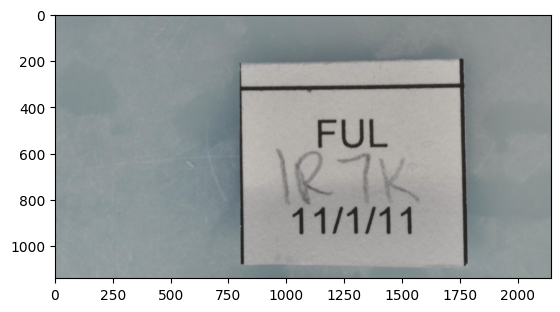

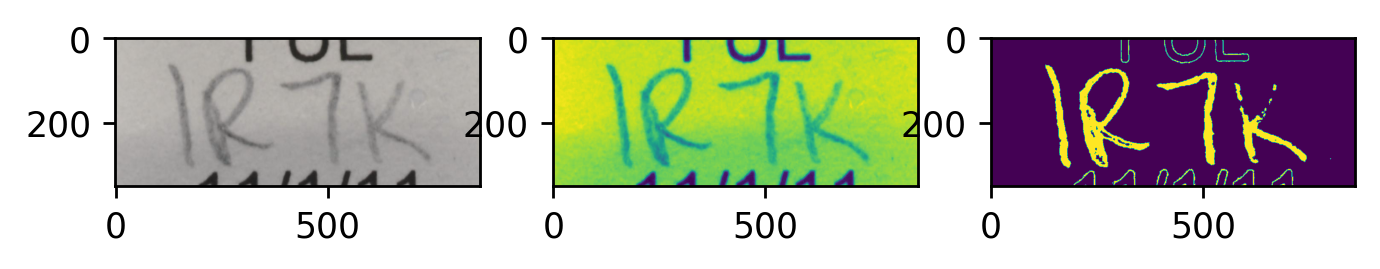

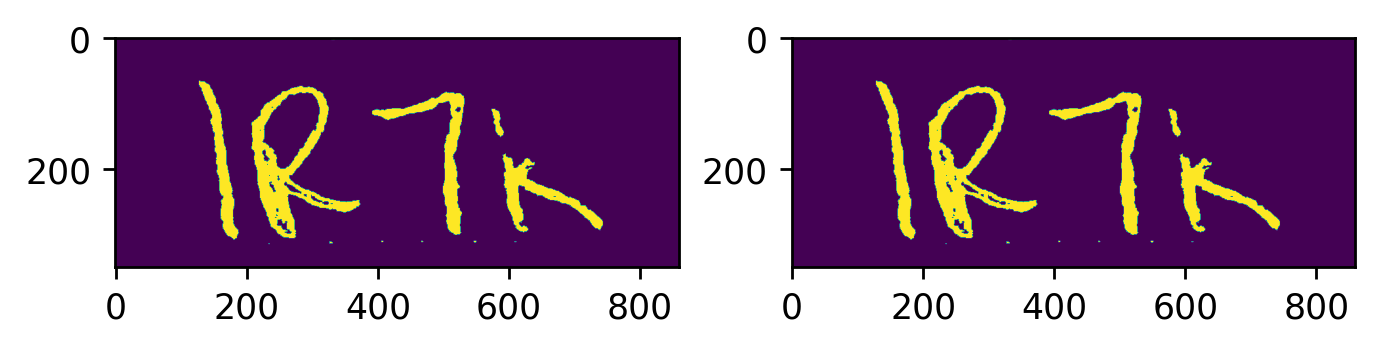

In [7]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[10])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

padx = 100
pady = 60
# Reduce the image to just the ID
reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

# Mask and remove for final image
masked_image = mask_and_remove(reduced_frame, verbose = True)

# Remove deltas
final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose = True)

print(output_string)

(upper thresh, lower_thresh) = (146.29, 35.33)


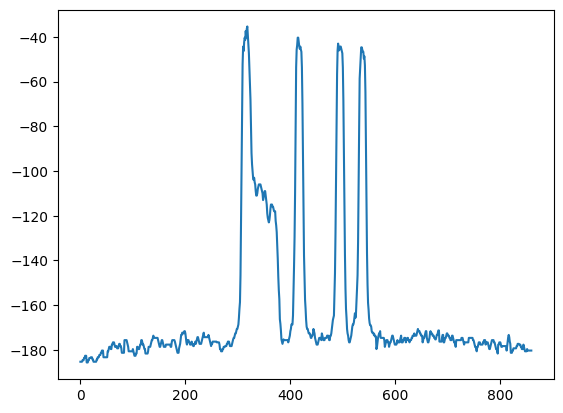

In [8]:
# Average out the RGB axis
averaged_frame = np.mean(reduced_frame,axis=2)


# White background masking
hist = np.histogram(averaged_frame, bins=100)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])

thresh_val = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
upper_thresh = centers[thresh_val] * 0.95

# Dark writing masking. Mask based on central row of frame
frame_shape = np.shape(averaged_frame)
row1 = -averaged_frame[2 * frame_shape[0] // 5][100:-100]
row2 = -averaged_frame[3 * frame_shape[0] // 5][100:-100]
rows = np.concatenate((row1, row2))
rows = row2 = -averaged_frame[1]
row_mean = np.mean(rows)
row_max = np.max(rows)
row_min = np.min(rows)
peaks,_ = scipy.signal.find_peaks(rows, height = row_mean + ((row_max - row_min) / 5), distance=4)

values = []
for peak in peaks:
    values.append(-rows[peak])

sorted_values = np.sort(values)

lower_thresh = sorted_values[0] * 1

averaged_frame[averaged_frame>upper_thresh] = 0
averaged_frame[averaged_frame<lower_thresh] = 0
averaged_frame[averaged_frame!=0] = 255

plt.plot(rows)
print('(upper thresh, lower_thresh) = (%.2f, %.2f)' %(upper_thresh, lower_thresh))

150.38083333333333

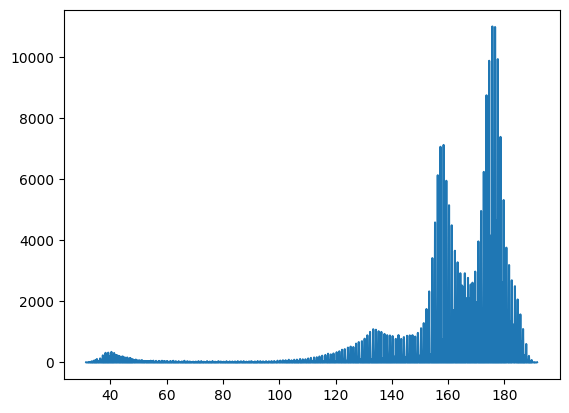

In [9]:
averaged_frame = np.mean(reduced_frame,axis=2)
hist = np.histogram(averaged_frame, bins=1000)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])
plt.plot(centers, hist[0])

thresh = np.argmax(hist[0] > np.max(hist[0]) * 0.1)
centers[thresh]

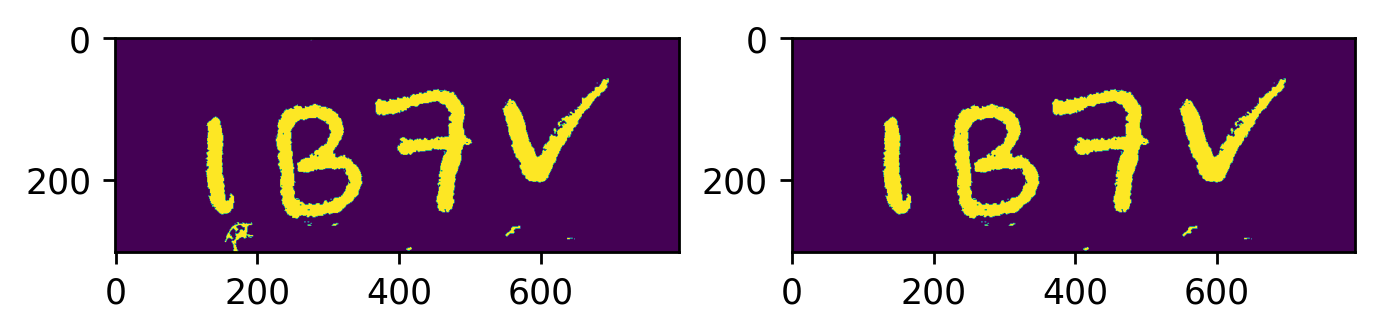

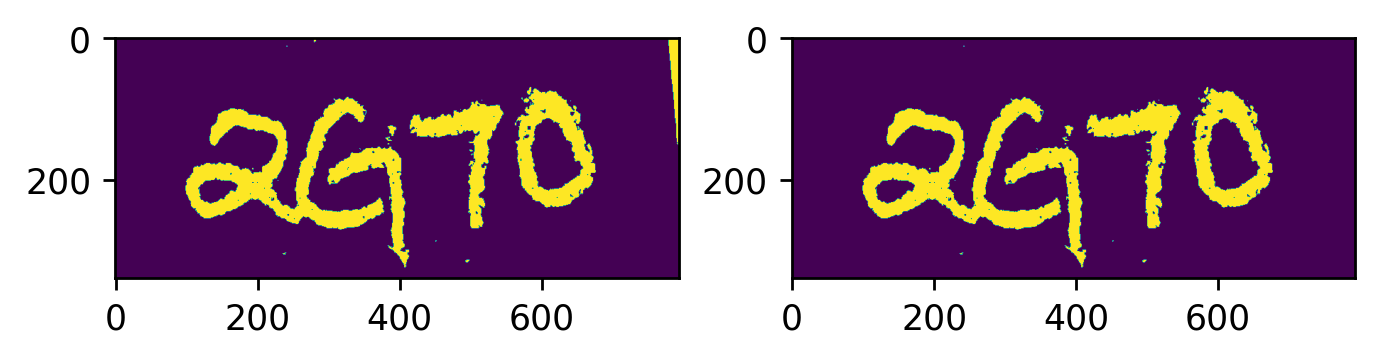

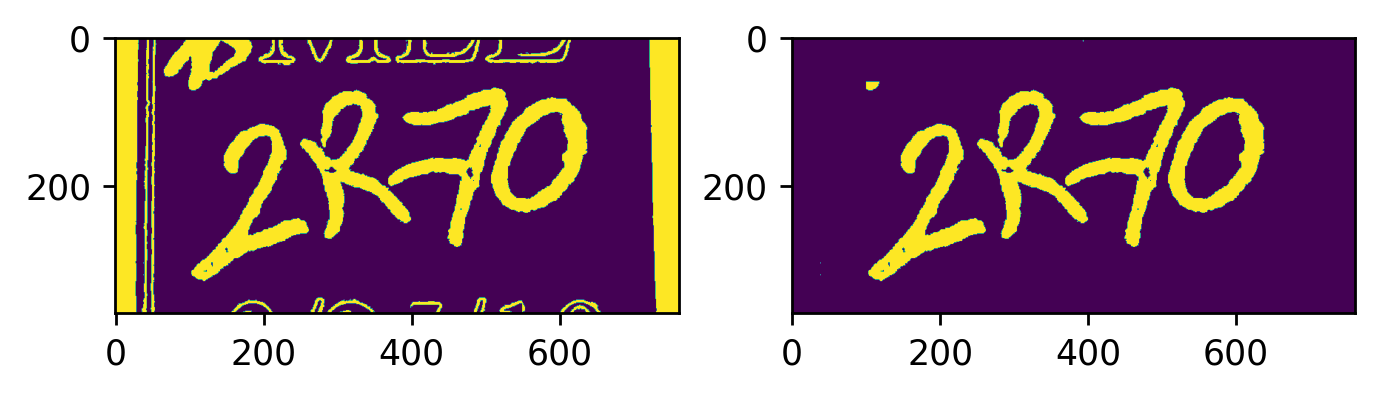

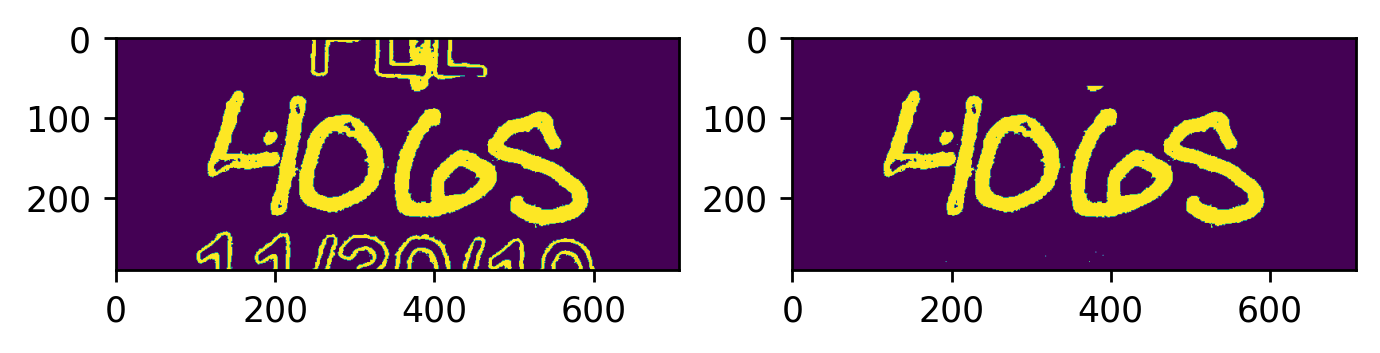

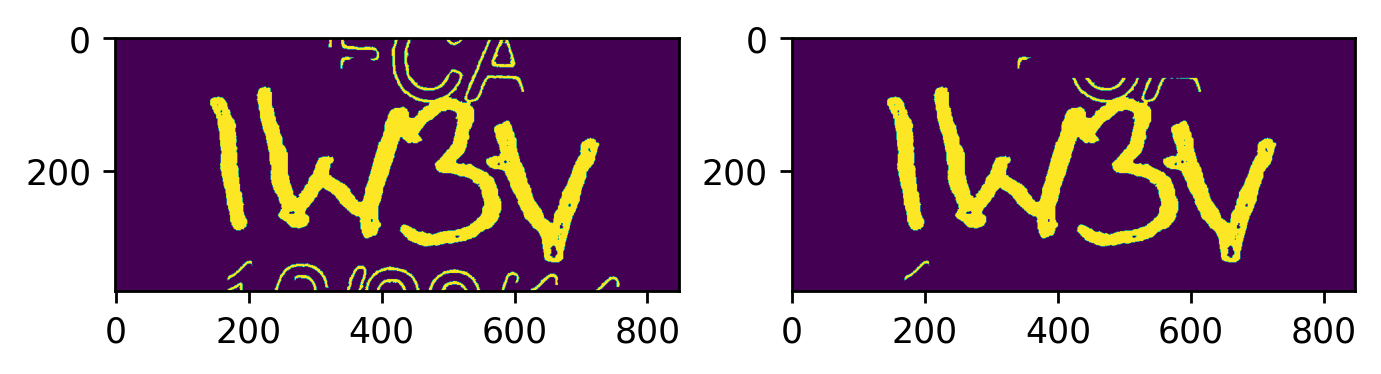

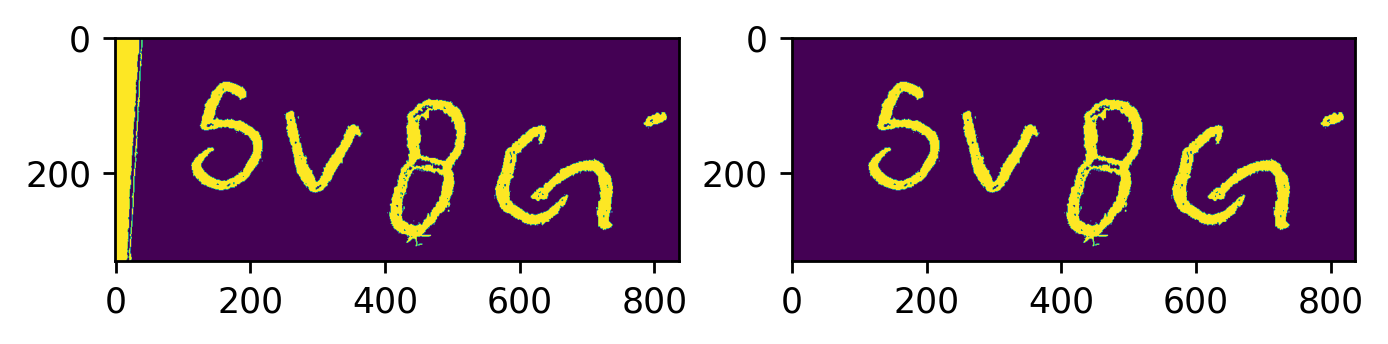

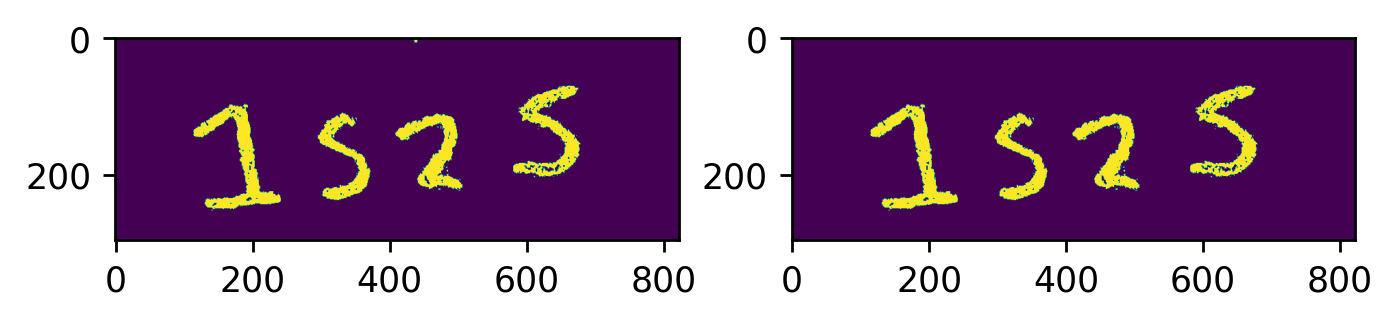

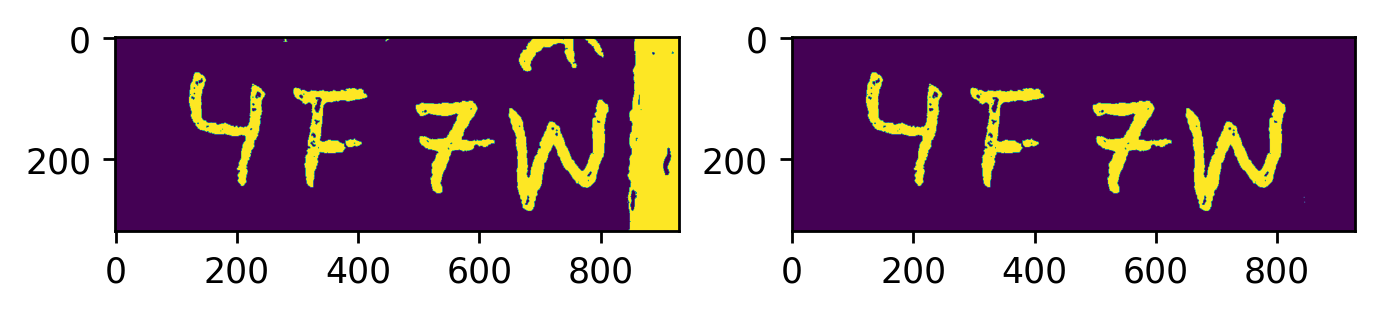

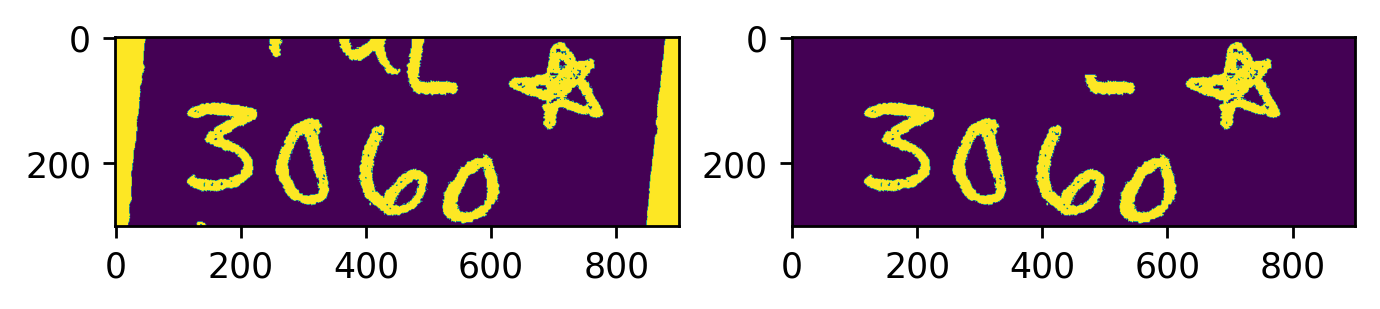

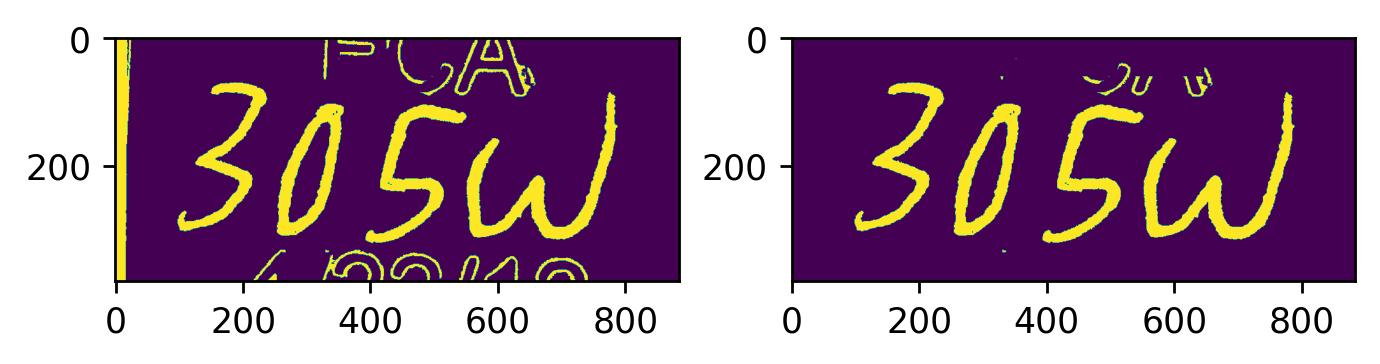

In [10]:
%matplotlib inline
padx = 100
pady = 60
for i in range(10):
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[i])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=100, pady=80)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose = True)
    
    except:
        pass

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 576 lower height: 457
U pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: U upper height: 577 lower height: 457
L pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: L upper height: 578 lower height: 458
Z pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:0
character: Z upper height: 819 lower height: 567
B pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:1
character: B upper height: 819 lower height: 567
3 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:2
character: 3 upper height: 820 lower height: 568
0 pageno:0 blockno:0 paragraphno:1 wordno:0 symbolno:3
character: 0 upper height: 820 lower height: 568
1 pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:0
character: 1 upper height: 964 lower height: 845
1 pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:1
character: 1 upper height: 963 lower height: 844
/ pageno:0 blockno:0 paragraphno:2 wordno:0 symbolno:2
character

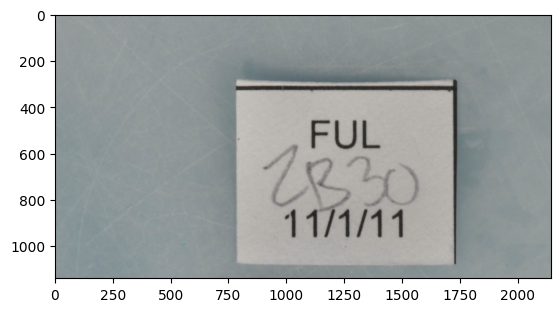

In [11]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[12])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

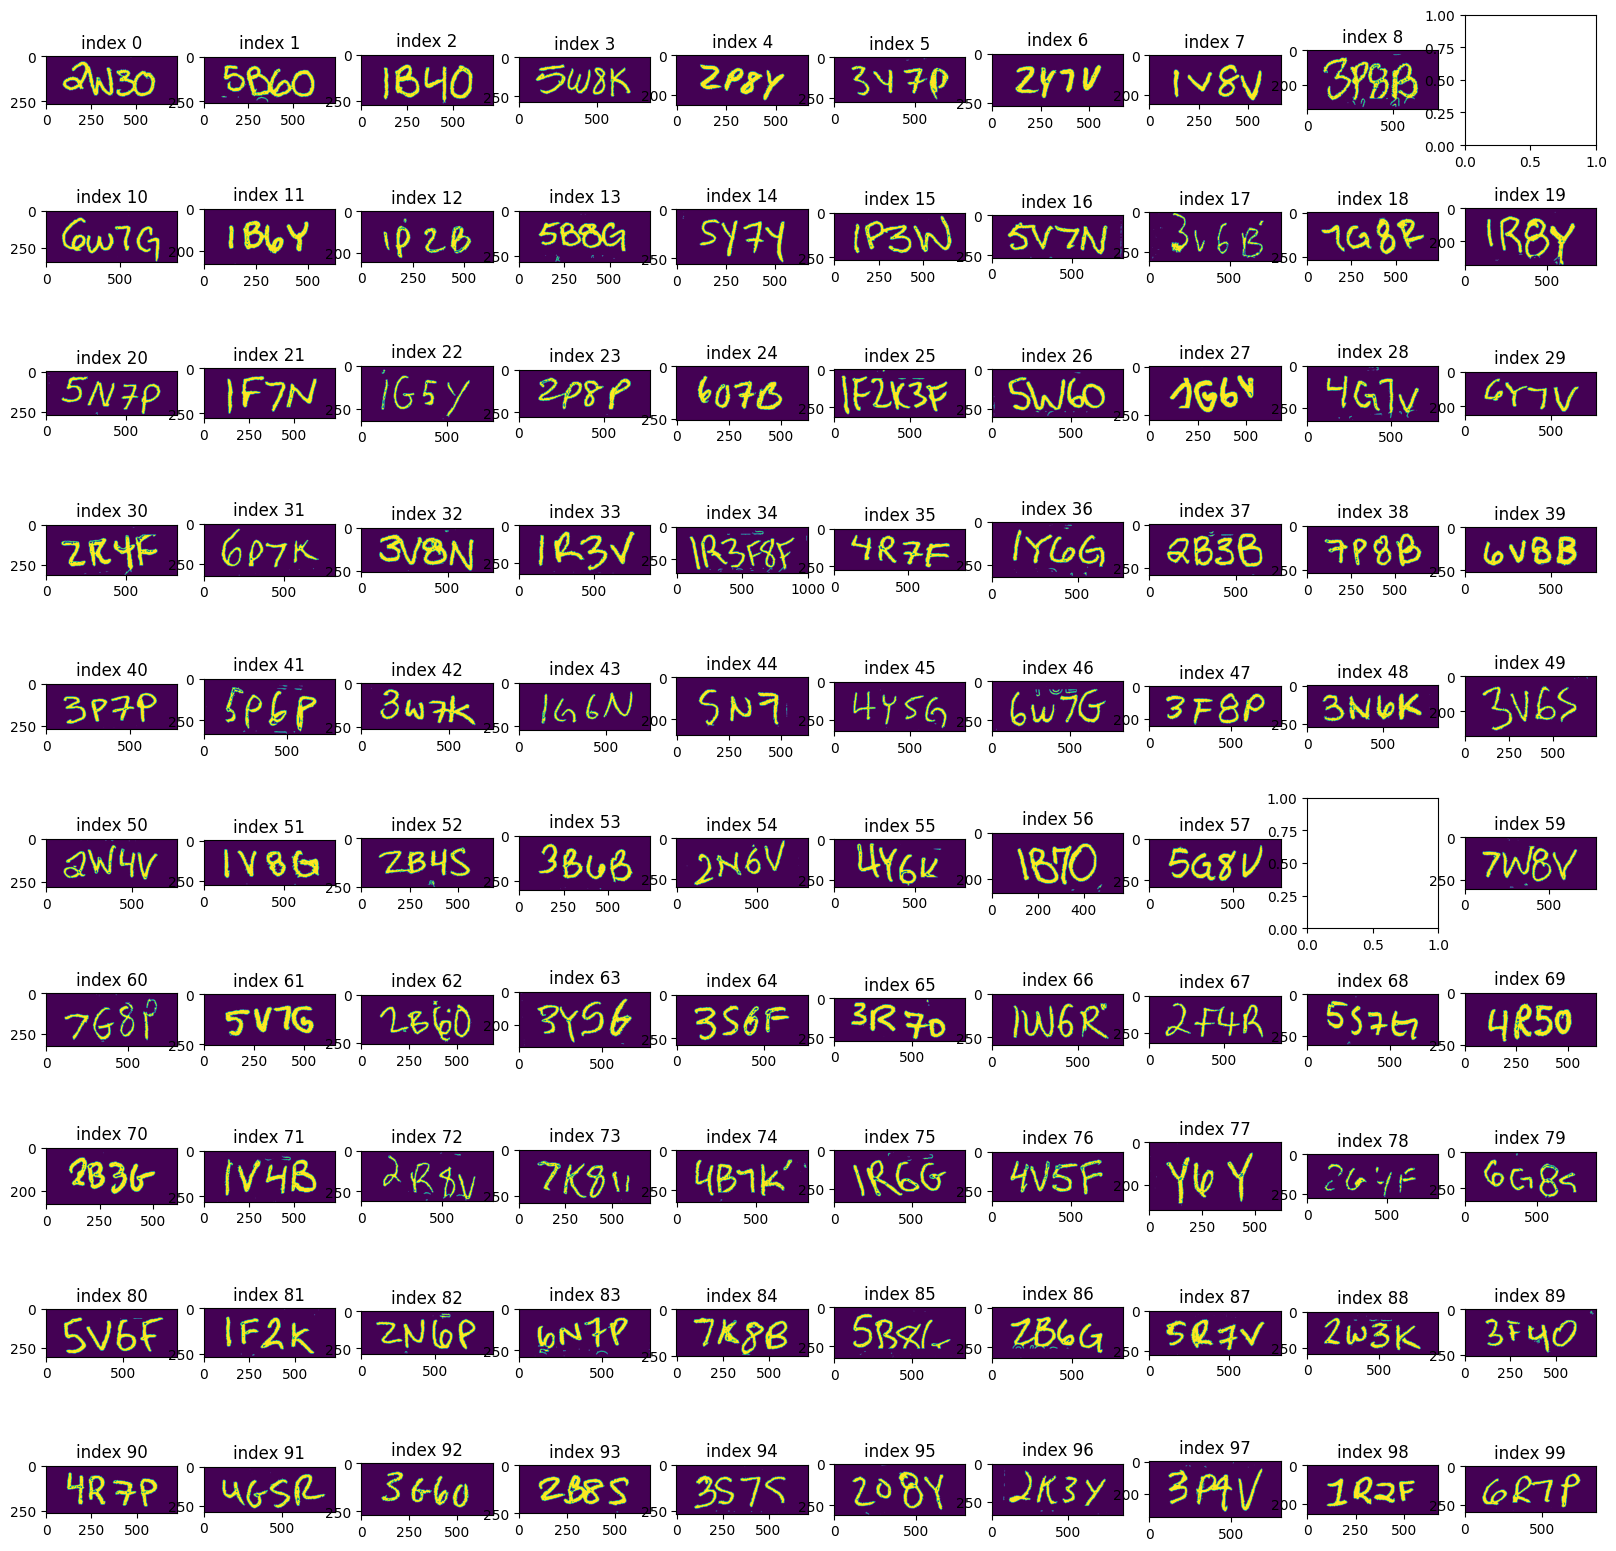

In [12]:
client = vision.ImageAnnotatorClient()
fig,ax = plt.subplots(10,10, figsize=(20,20))
padx = 100
pady = 60
for i in range(100):
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[100 + i])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose = False)

        ax[i // 10, i % 10].imshow(final_image)
        ax[i // 10, i % 10].set_title('index %i' %i)

    except:
        pass